In [17]:
using LinearAlgebra, ForwardDiff, IntervalArithmetic, ColorBitstring, Plots
import ForwardDiff: derivative, gradient

# 1. Interval Arithmetic

In [18]:
x = Interval(1)/5
y = 1 + x

printlnbits(y.lo)
printbits(y.hi)

0011111111110011001100110011001100110011001100110011001100110011
0011111111110011001100110011001100110011001100110011001100110100

In [23]:
x = exp(Interval(1))
printlnbits(x.lo)
printbits(x.hi)

0100000000000101101111110000101010001011000101000101011101101001
0100000000000101101111110000101010001011000101000101011101101010

In [47]:
setprecision(500) do
    x = 2asin(Interval(big(1.0)))
    println(x.lo)
    print(x.hi)
end;

3.1415926535897932384626433832795028841971693993751058209749445923078164062862089986280348253421170679821480865132823066470938446095505822317253594081283
3.1415926535897932384626433832795028841971693993751058209749445923078164062862089986280348253421170679821480865132823066470938446095505822317253594081295

In [58]:
n = 100
x = Interval(1)
T = typeof(x)
Tridiagonal(ones(T, n-1), Vector((1:n)/x), ones(T, n-1)) \ [1; zeros(n-1)];

### pitfalls of interval arithmetic

In [62]:
A = randn(n,n);

In [64]:
A \ [Interval(1); zeros(n-1)] # algorithm is making bounds get big

100-element Vector{Interval{Float64}}:
  [0.00814388, 0.020351]
 [-0.0970457, -0.0862136]
 [-0.00273397, 0.00422985]
  [0.0295726, 0.0336347]
 [-0.0254514, -0.0220029]
  [0.0350331, 0.0398003]
  [0.0134727, 0.017572]
  [0.0650756, 0.06856]
  [0.0396311, 0.0421159]
  [0.0519793, 0.0535555]
 [-0.0338035, -0.0326608]
  [0.0874942, 0.0898569]
  [0.00886029, 0.00973047]
   ⋮
  [0.0652826, 0.0652827]
  [0.250886, 0.250887]
 [-0.093264, -0.0932639]
  [0.137714, 0.137715]
 [-0.133794, -0.133793]
 [-0.172791, -0.17279]
  [0.160448, 0.160449]
  [0.144223, 0.144224]
 [-0.0173338, -0.0173337]
  [0.106756, 0.106757]
 [-0.0474261, -0.047426]
  [0.0860012, 0.0860013]

In [72]:
A \ ([1; zeros(n-1)] .+ 0.000001randn.()) # stable to perturbation!

100-element Vector{Float64}:
  0.014248090136152943
 -0.09163059317709711
  0.0007477456175571313
  0.031604182581632945
 -0.02372730867166498
  0.037417384005595286
  0.015522345933144438
  0.06681792444377267
  0.040873775865597144
  0.05276790578410262
 -0.033232567353352734
  0.08867660739989205
  0.009295610457623787
  ⋮
  0.06528269141714053
  0.25088856245743074
 -0.0932655437841904
  0.13771579964761405
 -0.13379390251136392
 -0.17279209951687607
  0.16044867555421974
  0.1442257181065486
 -0.01733399834628664
  0.1067565636882468
 -0.04742646762579419
  0.08600153177935152

# 2. Dual numbers

Q: Can we combine complex numbers with Dual Numbers? YES!

In [40]:
# Dual(a,b) represents a + b*ϵ
struct Dual{T}
    a::T
    b::T
end

# Dual(a) represents a + 0*ϵ
Dual(a::Real) = Dual(a, zero(a)) # for real numbers we use a + 0ϵ

# Allow for a + b*ϵ syntax
const ϵ = Dual(0, 1)

import Base: +, *, -, /, ^, zero, exp, cos, one

one(d::Dual) = Dual(one(d.a), zero(d.b))

# support polynomials like 1 + x, x - 1, 2x or x*2 by reducing to Dual
+(x::Real, y::Dual) = Dual(x) + y
+(x::Dual, y::Real) = x + Dual(y)
-(x::Real, y::Dual) = Dual(x) - y
-(x::Dual, y::Real) = x - Dual(y)
*(x::Real, y::Dual) = Dual(x) * y
*(x::Dual, y::Real) = x * Dual(y)

# support x/2 (but not yet division of duals)
/(x::Dual, k::Real) = Dual(x.a/k, x.b/k)

# a simple recursive function to support x^2, x^3, etc.
function ^(x::Dual, k::Integer)
    if k < 0
        error("Not implemented")
    elseif k == 1
        x
    else
        x^(k-1) * x
    end
end

# Algebraic operationds for duals
-(x::Dual) = Dual(-x.a, -x.b)
+(x::Dual, y::Dual) = Dual(x.a + y.a, x.b + y.b)
-(x::Dual, y::Dual) = Dual(x.a - y.a, x.b - y.b)
*(x::Dual, y::Dual) = Dual(x.a*y.a, x.a*y.b + x.b*y.a)

exp(x::Dual) = Dual(exp(x.a), exp(x.a) * x.b)
cos(x::Dual) = Dual(cos(x.a), -sin(x.a) * x.b)

cos (generic function with 26 methods)

In [34]:
exp(cos(Dual(1.0+im, 1.0+0.0im)))

Dual{ComplexF64}(1.2651436024409444 - 1.9230454867202535im, -2.863799792726376 + 1.6936724570689254im)

## Dual numbers and higher order derivatives

In [42]:
f = x -> cos(3exp(x^2)sin(x))
fp = x -> derivative(f, x)
fpp = x -> derivative(fp, x)

#41 (generic function with 1 method)

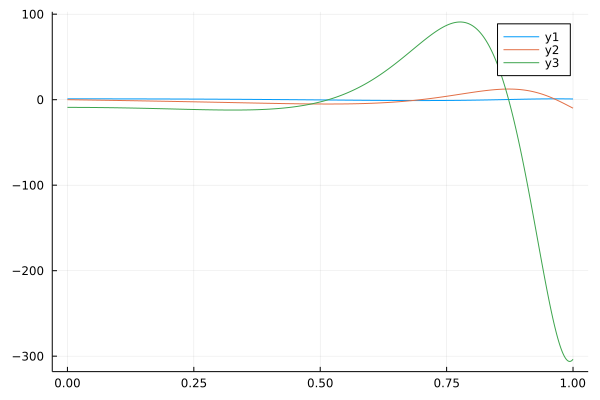

In [29]:
x = range(0,1; length=1000)
plot(x, f.(x))
plot!(x, fp.(x))
plot!(x, fpp.(x))

In [30]:
fp(0.1)

-0.9162493619930135

In [43]:
fpp(0.1)

-9.482298814244581

In [38]:
fp = x -> f(Dual(x,one(x))).b

#35 (generic function with 1 method)

In [41]:
fp(Dual(0.1,1.))

Dual{Float64}(-0.9162493619930135, -9.482298814244581)

In [45]:
f(Dual(Dual(0.1,1.0), Dual(1.0,0.0)))

Dual{Dual{Float64}}(Dual{Float64}(0.9545916421593101, -0.9162493619930135), Dual{Float64}(-0.9162493619930135, -9.482298814244581))

## Real solution to Q4.3

In [47]:
x = 2.0^53
x + 1 == x

true

In [48]:
nextfloat(x)+1 == nextfloat(x)

false